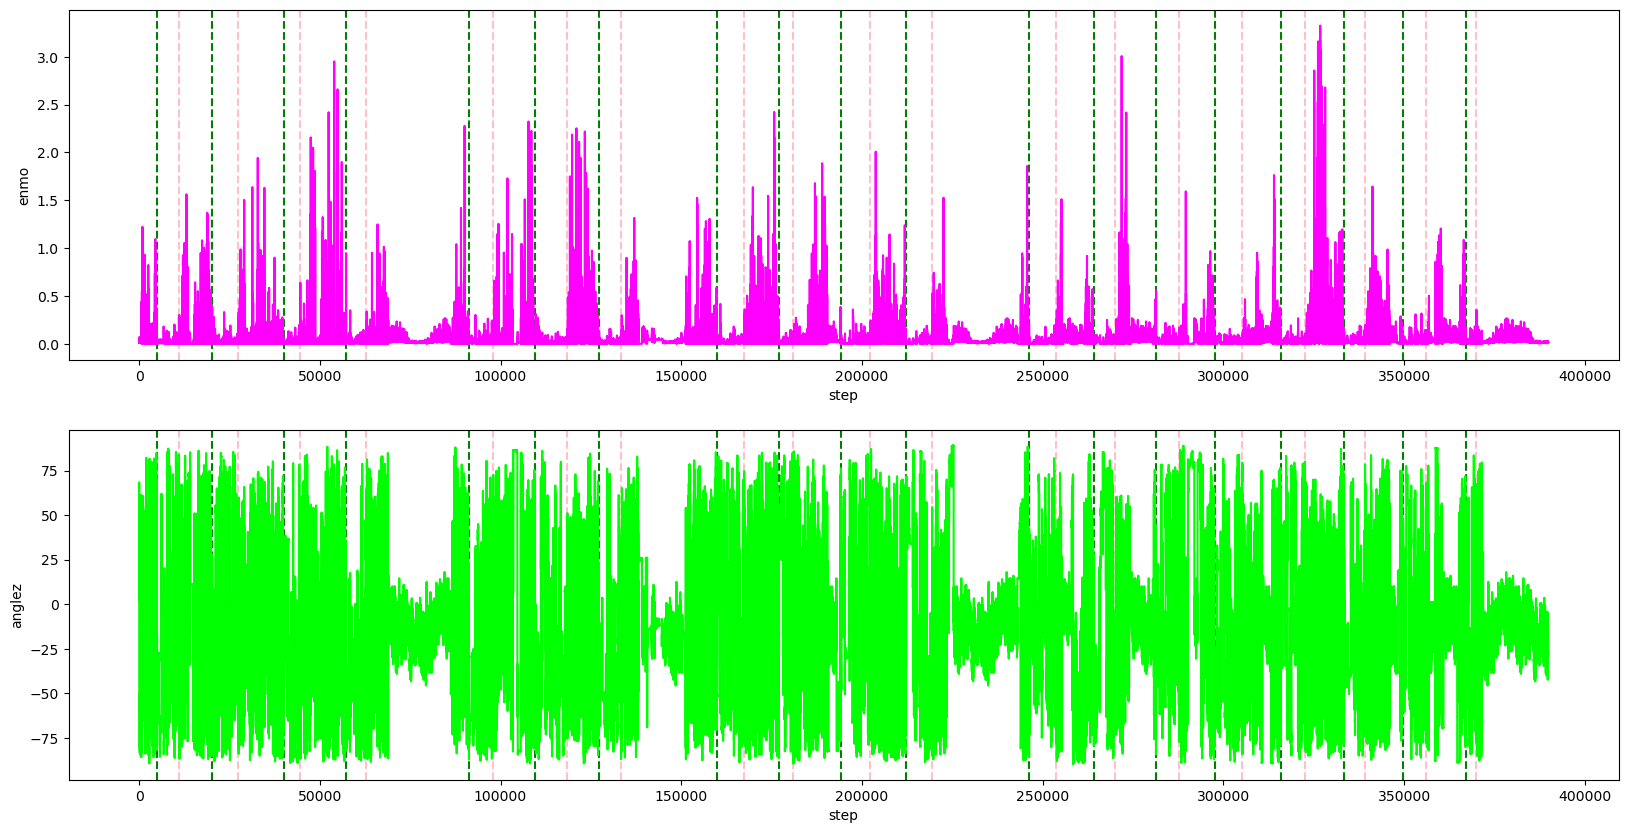

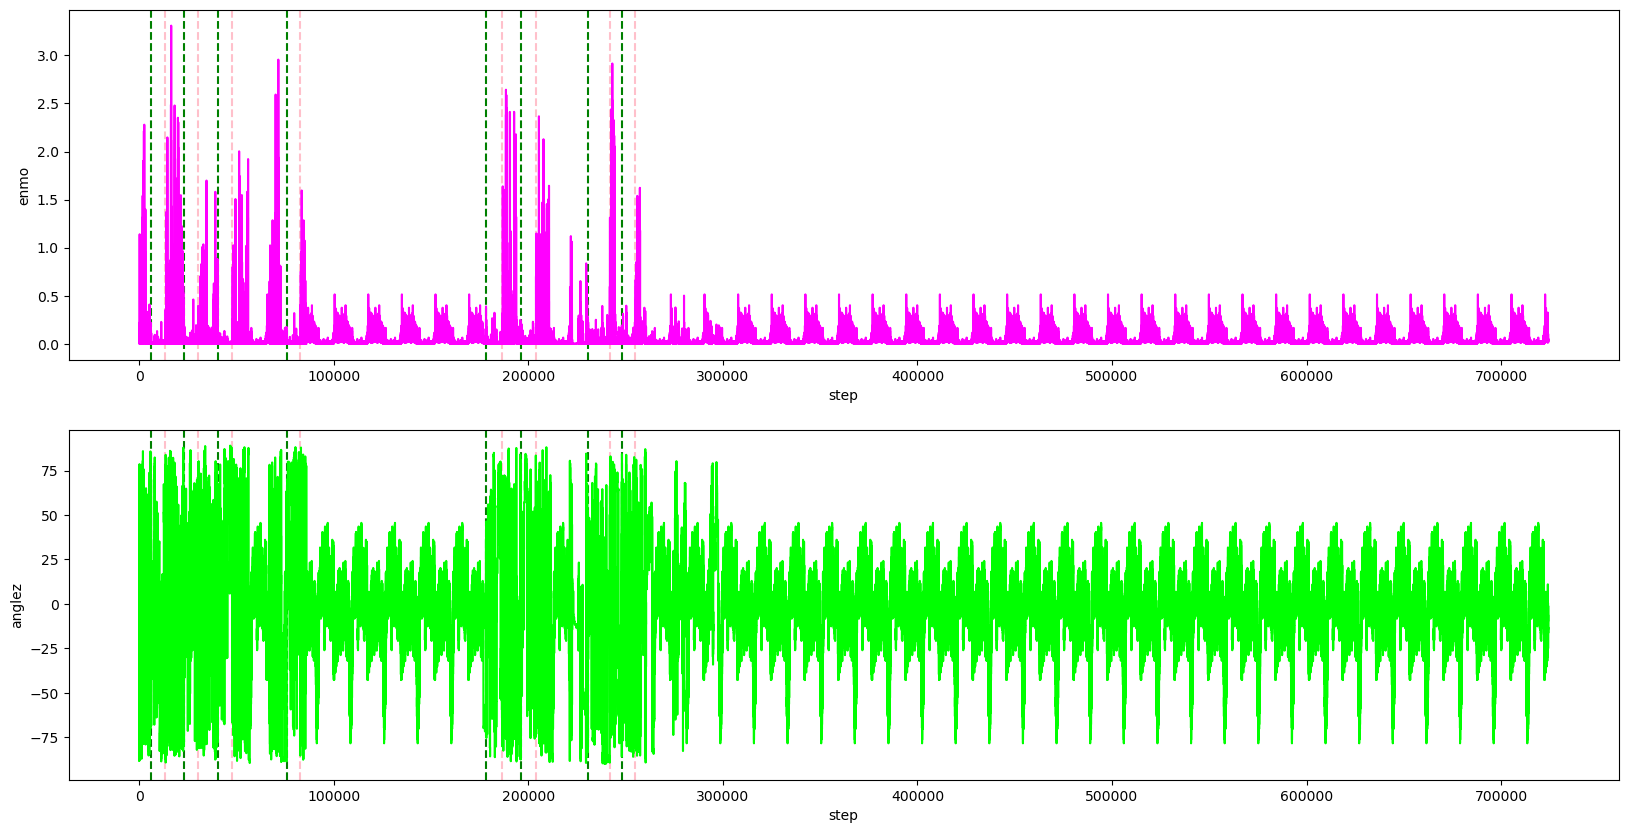

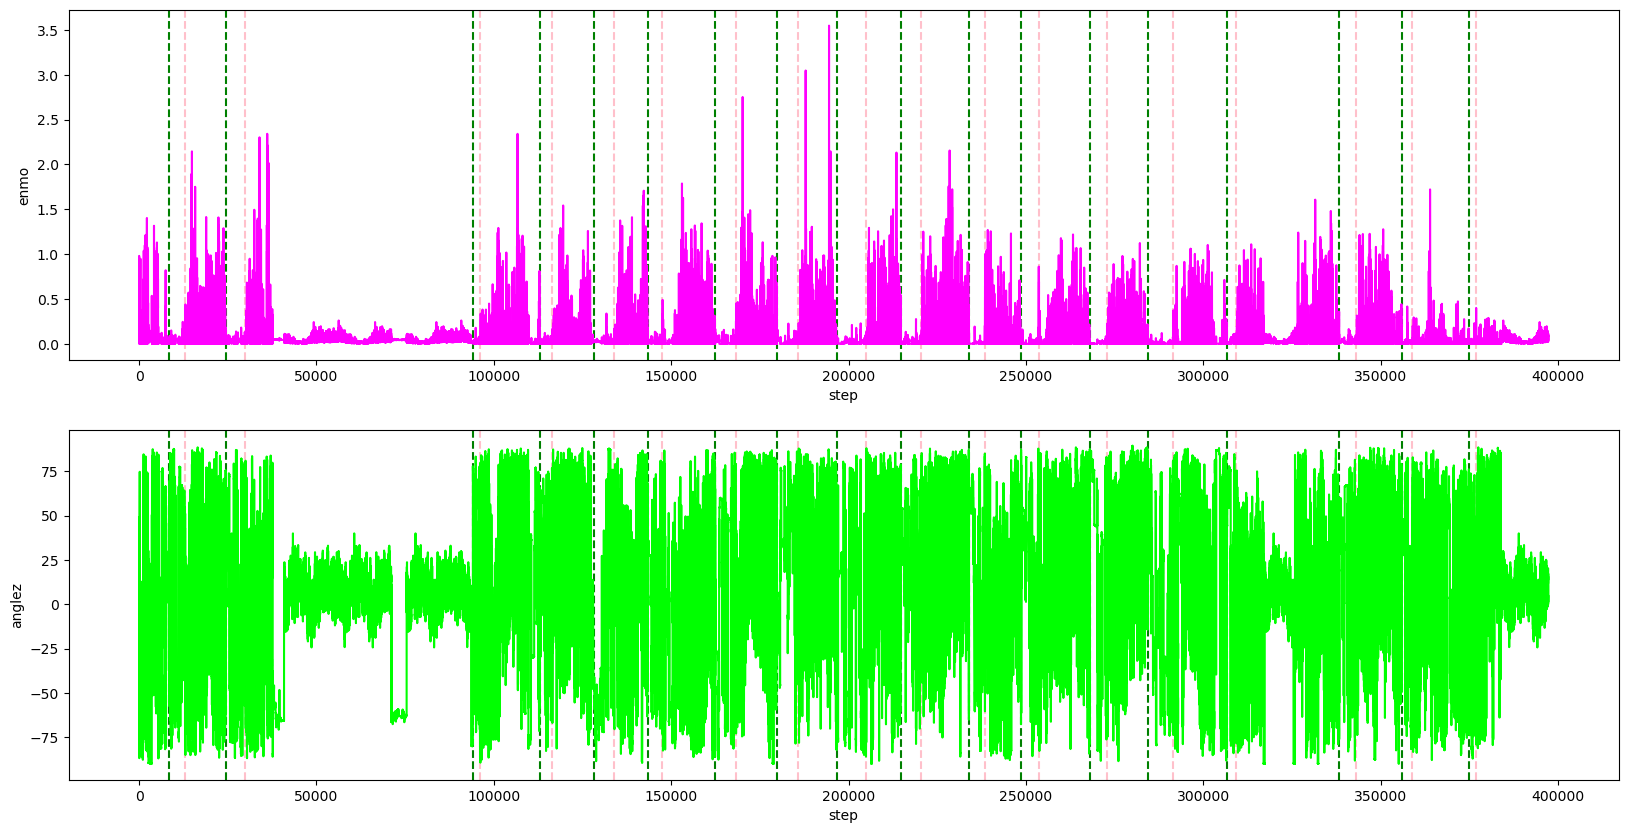

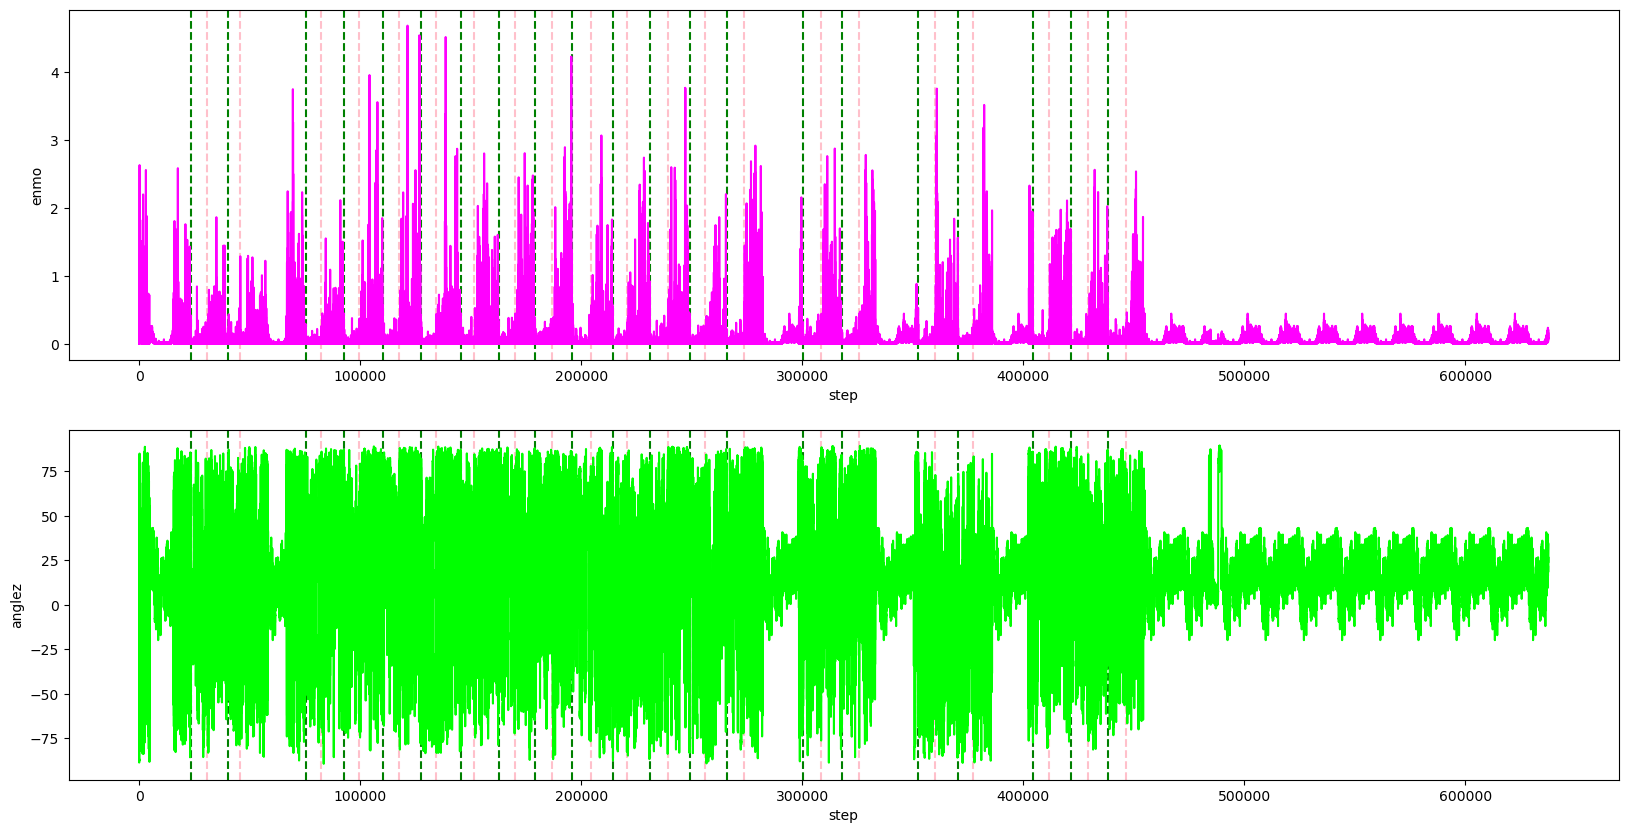

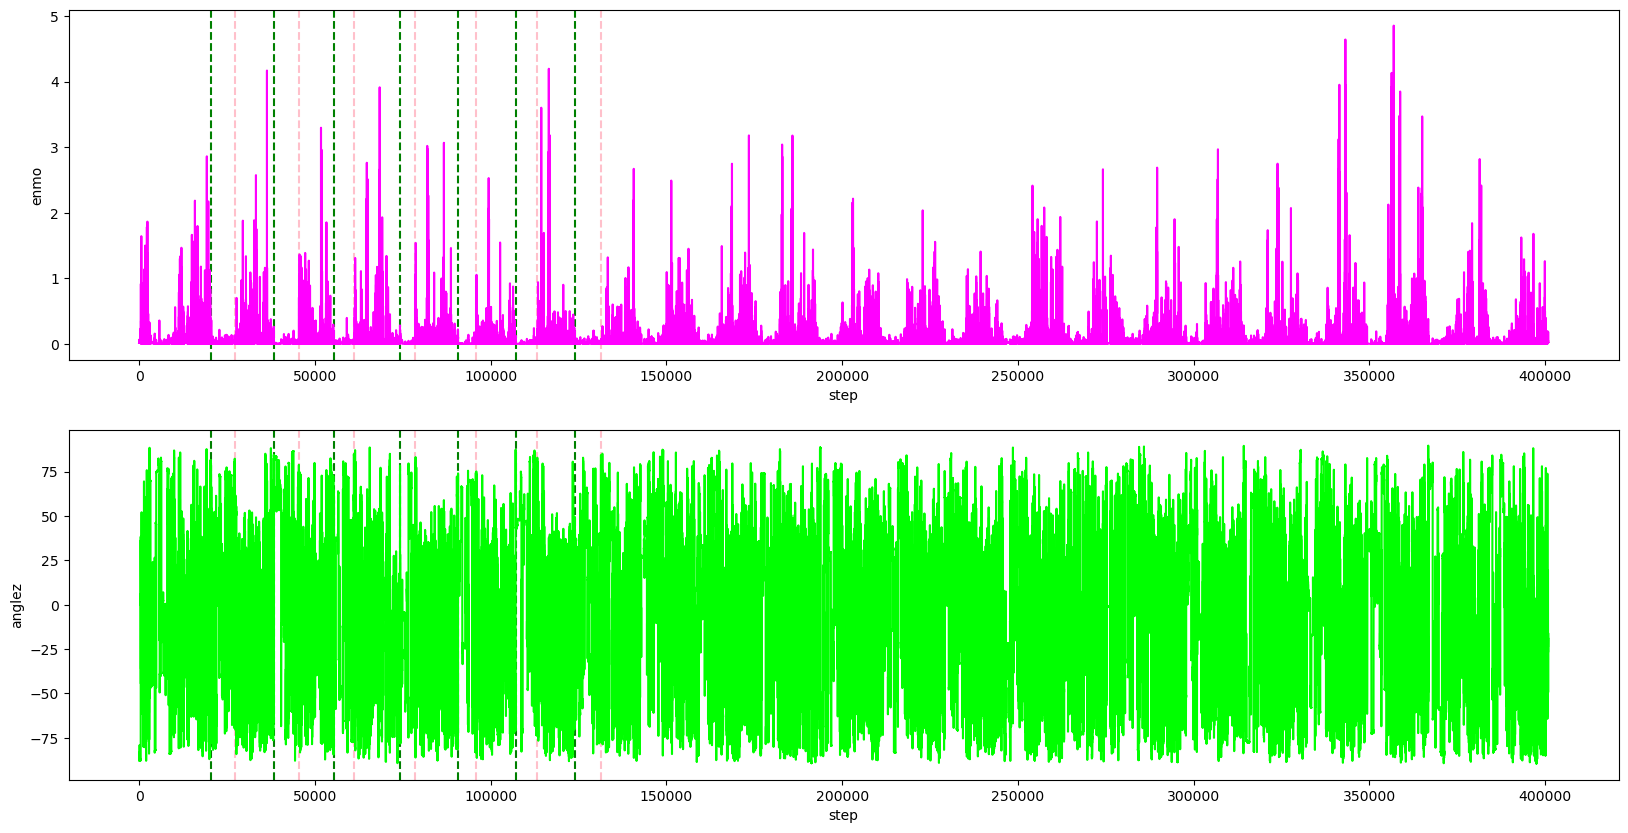

In [2]:
from pathlib import Path
import pyarrow.parquet as pq
import gc
import seaborn as sns
import matplotlib.pyplot as plt
import random
import pandas as pd

from sklearn.preprocessing import LabelEncoder

def plot_data(merged_data):
    fig, plot = plt.subplots(2, 1, figsize=(20, 10))

    for i in range(len(merged_data)):
        if merged_data['event'].values[i] == 'onset':
            plot[1].axvline(merged_data.index[i], linestyle="--", color="green", label="onset")
            plot[0].axvline(merged_data.index[i], linestyle="--", color="green", label="onset")

        if merged_data['event'].values[i] == 'wakeup':
            plot[1].axvline(merged_data.index[i], linestyle="--", color="pink", label='wakeup')
            plot[0].axvline(merged_data.index[i], linestyle="--", color="pink", label='wakeup')

    plot[0].plot(merged_data.index, merged_data['enmo'], label="enmo", color = "magenta")
    plot[0].set_ylabel('enmo')
    plot[0].set_xlabel('step')
    plot[1].plot(merged_data.index, merged_data['anglez'], label="anglez", color = "lime")
    plot[1].set_ylabel('anglez')
    plot[1].set_xlabel('step')

    plt.show()

# IDs
target_series_ids = ['038441c925bb', '03d92c9f6f8a', '0402a003dae9', '04f547b8017d', '05e1944c3818']

for target_series_id in target_series_ids:
    data_frames = []

    train_series = pq.ParquetFile('train_series.parquet')
    for batch in train_series.iter_batches():
        batch_df = batch.to_pandas()
        filtered_data = batch_df[batch_df['series_id'] == target_series_id]
        data_frames.append(filtered_data)

    # combine
    combined_data = pd.concat(data_frames, ignore_index=True)
    combined_data['timestamp'] = pd.to_datetime(combined_data['timestamp'], utc=True)

    train_events = pd.read_csv('train_events.csv')
    train_events['timestamp'] = pd.to_datetime(train_events['timestamp'], utc=True)

    # merge the combined data with event data
    filtered_events = train_events[train_events['series_id'] == target_series_id]
    merged_data = pd.merge(combined_data, filtered_events, on=['timestamp', 'series_id'], how='left')

    # call the plot_data function for each target_series_id
    plot_data(merged_data)


In [52]:
# downsize csv
file_path = 'train_events.csv'
df = pd.read_csv(file_path)

unique_series_ids = df['series_id'].unique()

# 40 random unique series IDs
series_ids_to_keep = random.sample(list(unique_series_ids), min(40, len(unique_series_ids)))

filtered_events = df[df['series_id'].isin(series_ids_to_keep)]

filtered_file_path = 'filtered_train_events.csv'
filtered_events.to_csv(filtered_file_path, index=False)

print(f'The CSV file has been filtered and saved to {filtered_file_path}')

The CSV file has been filtered and saved to filtered_train_events.csv


In [78]:
# same ids for parquet
train_series = pq.ParquetFile('train_series.parquet')
data_frames = []

for batch in train_series.iter_batches():
    batch_df = batch.to_pandas()

    # keep only the series_ids_to_keep
    batch_df = batch_df[batch_df['series_id'].isin(series_ids_to_keep)]

    data_frames.append(batch_df)

filtered_train_series = pd.concat(data_frames, ignore_index=True)

# relevant columns
filtered_train_series = filtered_train_series[['series_id', 'enmo', 'anglez', 'timestamp']]

print(filtered_train_series.head())

      series_id    enmo     anglez                 timestamp
0  0ef7d94fde99  0.0266  34.612598  2018-01-26T17:30:00-0500
1  0ef7d94fde99  0.0277  47.057598  2018-01-26T17:30:05-0500
2  0ef7d94fde99  0.0205  62.150902  2018-01-26T17:30:10-0500
3  0ef7d94fde99  0.0312  67.852699  2018-01-26T17:30:15-0500
4  0ef7d94fde99  0.0306  66.735497  2018-01-26T17:30:20-0500


In [79]:
filtered_train_series.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18639000 entries, 0 to 18638999
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   series_id  object 
 1   enmo       float32
 2   anglez     float32
 3   timestamp  object 
dtypes: float32(2), object(2)
memory usage: 426.6+ MB


In [80]:
filtered_train_series

,series_id,enmo,anglez,timestamp
0,0ef7d94fde99,0.0266,34.612598,2018-01-26T17:30:00-0500
1,0ef7d94fde99,0.0277,47.057598,2018-01-26T17:30:05-0500
2,0ef7d94fde99,0.0205,62.150902,2018-01-26T17:30:10-0500
3,0ef7d94fde99,0.0312,67.852699,2018-01-26T17:30:15-0500
4,0ef7d94fde99,0.0306,66.735497,2018-01-26T17:30:20-0500
...,...,...,...,...
18638995,fe90110788d2,0.0204,-27.277500,2017-09-08T00:14:35-0400
18638996,fe90110788d2,0.0233,-27.032499,2017-09-08T00:14:40-0400
18638997,fe90110788d2,0.0202,-26.841200,2017-09-08T00:14:45-0400
18638998,fe90110788d2,0.0199,-26.723900,2017-09-08T00:14:50-0400


In [56]:
filtered_events

,series_id,night,event,step,timestamp
794,0ef7d94fde99,1,onset,3684.0,2018-01-26T22:37:00-0500
795,0ef7d94fde99,1,wakeup,9888.0,2018-01-27T07:14:00-0500
796,0ef7d94fde99,2,onset,20340.0,2018-01-27T21:45:00-0500
797,0ef7d94fde99,2,wakeup,27444.0,2018-01-28T07:37:00-0500
798,0ef7d94fde99,3,onset,36168.0,2018-01-28T19:44:00-0500
...,...,...,...,...,...
14503,fe90110788d2,33,wakeup,560604.0,2017-09-06T04:07:00-0400
14504,fe90110788d2,34,onset,574620.0,2017-09-06T23:35:00-0400
14505,fe90110788d2,34,wakeup,581604.0,2017-09-07T09:17:00-0400
14506,fe90110788d2,35,onset,NaN,NaN


In [57]:
filtered_events.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2162 entries, 794 to 14507
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   series_id  2162 non-null   object 
 1   night      2162 non-null   int64  
 2   event      2162 non-null   object 
 3   step       1433 non-null   float64
 4   timestamp  1433 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 101.3+ KB


In [58]:
len(list(filtered_events.series_id.unique()))

40

In [59]:
night_counts = filtered_events.groupby('night').size().reset_index(name='count')
night_counts

,night,count
0,1,80
1,2,80
2,3,80
3,4,80
4,5,80
5,6,80
6,7,80
7,8,80
8,9,78
9,10,78


In [60]:
series_id = filtered_events.groupby('series_id').size().reset_index(name='count')
series_id

,series_id,count
0,0ef7d94fde99,44
1,1087d7b0ff2e,48
2,154fe824ed87,64
3,3be2f86c3e45,46
4,3d53bfea61d6,46
5,4ab54be1a403,48
6,5acc9d63b5fd,48
7,5e816f11f5c3,16
8,5f40907ec171,42
9,6a4cd123bd69,70


In [61]:
# remove NaN values
df_train_events = filtered_events.dropna(axis=0)#, ignore_index=True)
df_train_events.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1433 entries, 794 to 14505
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   series_id  1433 non-null   object 
 1   night      1433 non-null   int64  
 2   event      1433 non-null   object 
 3   step       1433 non-null   float64
 4   timestamp  1433 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 67.2+ KB


In [63]:
# look at one patient
sample_events = filtered_events[filtered_events['series_id'] == 'c908a0ad3e31']
sample_events

,series_id,night,event,step,timestamp
10636,c908a0ad3e31,1,onset,4992.0,2018-02-02T23:56:00-0500
10637,c908a0ad3e31,1,wakeup,10656.0,2018-02-03T07:48:00-0500
10638,c908a0ad3e31,2,onset,22332.0,2018-02-04T00:01:00-0500
10639,c908a0ad3e31,2,wakeup,31704.0,2018-02-04T13:02:00-0500
10640,c908a0ad3e31,3,onset,39240.0,2018-02-04T23:30:00-0500
10641,c908a0ad3e31,3,wakeup,44100.0,2018-02-05T06:15:00-0500
10642,c908a0ad3e31,4,onset,56340.0,2018-02-05T23:15:00-0500
10643,c908a0ad3e31,4,wakeup,61164.0,2018-02-06T05:57:00-0500
10644,c908a0ad3e31,5,onset,73428.0,2018-02-06T22:59:00-0500
10645,c908a0ad3e31,5,wakeup,78372.0,2018-02-07T05:51:00-0500


In [81]:
# look at one patient
sample_series = filtered_train_series[filtered_train_series['series_id'] == 'c908a0ad3e31']
sample_series

,series_id,enmo,anglez,timestamp
11904120,c908a0ad3e31,0.0322,-86.091904,2018-02-02T17:00:00-0500
11904121,c908a0ad3e31,0.0320,-85.888702,2018-02-02T17:00:05-0500
11904122,c908a0ad3e31,0.0318,-85.888702,2018-02-02T17:00:10-0500
11904123,c908a0ad3e31,0.0510,-87.152100,2018-02-02T17:00:15-0500
11904124,c908a0ad3e31,0.0319,-88.737297,2018-02-02T17:00:20-0500
...,...,...,...,...
12306595,c908a0ad3e31,0.0149,-3.526700,2018-02-25T23:59:35-0500
12306596,c908a0ad3e31,0.0115,-3.292500,2018-02-25T23:59:40-0500
12306597,c908a0ad3e31,0.0123,-4.821200,2018-02-25T23:59:45-0500
12306598,c908a0ad3e31,0.0128,-6.340500,2018-02-25T23:59:50-0500


In [82]:
filtered_train_series = filtered_train_series.dropna()
filtered_train_series

,series_id,enmo,anglez,timestamp
0,0ef7d94fde99,0.0266,34.612598,2018-01-26T17:30:00-0500
1,0ef7d94fde99,0.0277,47.057598,2018-01-26T17:30:05-0500
2,0ef7d94fde99,0.0205,62.150902,2018-01-26T17:30:10-0500
3,0ef7d94fde99,0.0312,67.852699,2018-01-26T17:30:15-0500
4,0ef7d94fde99,0.0306,66.735497,2018-01-26T17:30:20-0500
...,...,...,...,...
18638995,fe90110788d2,0.0204,-27.277500,2017-09-08T00:14:35-0400
18638996,fe90110788d2,0.0233,-27.032499,2017-09-08T00:14:40-0400
18638997,fe90110788d2,0.0202,-26.841200,2017-09-08T00:14:45-0400
18638998,fe90110788d2,0.0199,-26.723900,2017-09-08T00:14:50-0400


In [74]:
filtered_events = filtered_events.dropna()

# change event to either 0 or 1
filtered_events['event'] = filtered_events['event'].replace({'onset': 0, 'wakeup': 1})
filtered_events

,series_id,night,event,step,timestamp
794,0ef7d94fde99,1,0,3684.0,2018-01-26T22:37:00-0500
795,0ef7d94fde99,1,1,9888.0,2018-01-27T07:14:00-0500
796,0ef7d94fde99,2,0,20340.0,2018-01-27T21:45:00-0500
797,0ef7d94fde99,2,1,27444.0,2018-01-28T07:37:00-0500
798,0ef7d94fde99,3,0,36168.0,2018-01-28T19:44:00-0500
...,...,...,...,...,...
14501,fe90110788d2,32,1,547152.0,2017-09-05T09:26:00-0400
14502,fe90110788d2,33,0,556560.0,2017-09-05T22:30:00-0400
14503,fe90110788d2,33,1,560604.0,2017-09-06T04:07:00-0400
14504,fe90110788d2,34,0,574620.0,2017-09-06T23:35:00-0400


In [84]:
# merge data based on timestamp
merged_data = pd.merge(filtered_train_series, filtered_events[['timestamp', 'event']], on='timestamp', how='inner')

print(merged_data.head())


      series_id    enmo     anglez                 timestamp  event
0  0ef7d94fde99  0.0176 -79.718300  2018-01-26T22:37:00-0500      0
1  3be2f86c3e45  0.0349  -6.388900  2018-01-26T22:37:00-0500      0
2  89bd631d1769  0.0000  21.250601  2018-01-26T22:37:00-0500      0
3  0ef7d94fde99  0.0100  56.061001  2018-01-27T00:05:00-0500      0
4  3be2f86c3e45  0.0273  11.473700  2018-01-27T00:05:00-0500      0


In [85]:
merged_data

,series_id,enmo,anglez,timestamp,event
0,0ef7d94fde99,0.0176,-79.718300,2018-01-26T22:37:00-0500,0
1,3be2f86c3e45,0.0349,-6.388900,2018-01-26T22:37:00-0500,0
2,89bd631d1769,0.0000,21.250601,2018-01-26T22:37:00-0500,0
3,0ef7d94fde99,0.0100,56.061001,2018-01-27T00:05:00-0500,0
4,3be2f86c3e45,0.0273,11.473700,2018-01-27T00:05:00-0500,0
...,...,...,...,...,...
3659,fe90110788d2,0.0000,25.648399,2017-08-09T07:03:00-0400,1
3660,fe90110788d2,0.0085,-52.940399,2017-08-09T20:52:00-0400,0
3661,fe90110788d2,0.0191,-68.378899,2017-08-10T05:51:00-0400,1
3662,fe90110788d2,0.0201,-8.322300,2017-08-10T23:36:00-0400,0


In [88]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

X = merged_data[['enmo', 'anglez']]
y = merged_data['event']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = DecisionTreeClassifier()

model.fit(X_train, y_train)

predictions = model.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy}')

print(classification_report(y_test, predictions))

Accuracy: 0.5443383356070941
              precision    recall  f1-score   support

           0       0.57      0.53      0.55       386
           1       0.52      0.56      0.54       347

    accuracy                           0.54       733
   macro avg       0.54      0.54      0.54       733
weighted avg       0.55      0.54      0.54       733



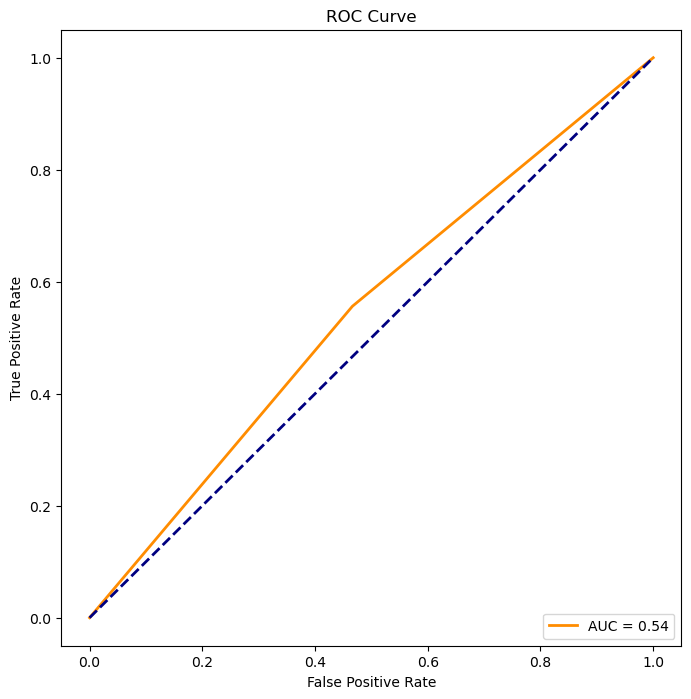

In [89]:
# ROC curve
from sklearn.metrics import roc_curve, roc_auc_score

y_probs = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_probs)

auc = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()